# Class 21: Sampling Networks

In this class, we're going to practice sampling a large-ish citation graph to learn about ways to deal with large networks. The sampling procedures and evaluation paradigms we'll use will closely follow [Leskovec and Faloutsos (2006)](https://cs.stanford.edu/people/jure/pubs/sampling-kdd06.pdf). 

## Why Sample?
Sometimes it just isn't feasible to analyze an entire graph. We might not have enough time, computational budget, or storage space to look at the entirety of an enormous network. Some algorithms for computing, say, centrality or shortest paths become infeasible (or at least really annoying) on graphs that have, say, billions of edges. The research questions Leskovec and Faloutsos focus on are the following:
1. How do we sample? What method(s) should we use?
2. How small can our sample size be?
3. How do we scale up the measurements from our sample (e.g. diameter) to get estimates for the whole graph?
4. How do we know if we've done a good job sampling & scaling up?

### Two sampling goals
L & F introduce two different goals for sampling a network. The first ideal sample is a **scaled-down** sample: our sample graph $S$, derived from our whole graph $G$, has properties that are either similar to $G$ or predictably scaled down. Our second ideal sampling goal is a **back-in-time** sample; this one looks like $G$ *at the time it was the size of $S$*. 

### What properties do we care about?
#### For a static snapshot:
* In-degree distribution (should probably follow a heavy-tailed power law distribution)
* Out-degree distribution (should also probably follow a heavy-tailed power law distribution)
* The distribution of weakly connected components' sizes (weakly connected in a directed graph = an **undirected** path exists between any node pair $(u,v)$ in the component)
* The distribution of strongly connected components' sizes (strongly connected in a directed graph = a **directed** path exists between any node pair $(u, v)$ in the component). 
* Hop-plot (the number of reachable pairs of nodes $P(h)$ at distance $h$ or less)
* Hop-plot on the largest WCC (weakly connected component)
* The distribution of the first left singular vector of the graph adjacency matrix versus the rank
* The distribution of singular values of the graph adjacency matrix versus the rank
* The distribution of the clustering coefficient (averaged over each degree)

#### For a back-in-time sample:
* Densification Power Law: the average degree of nodes over time (should increase over time according to $k(t) \propto n(t)^\alpha$, where $\alpha > 1$)
* The effective diameter over time: the minimum number of hops in which 90% of nodes can reach each other. This should shrink or stabilize as the graph grows over time
* The normalized size of the largest connected component over time
* The largest singular value of the graph adjacency matrix over time.
* Average per-degree clustering coefficient over time

(these are measured on a sequence of graphs over time!)

#### Visiting probability:
We also look at visiting probability, which is the probability that if you start a random walk at node $v$ you visit node $w$ (for every node $v$, we calculate the stationary distribution of a random walk starting at $v$ and compare the distributions in $S$ and $G$). 

### Interactive Moment
What kinds of properties do you think we should care about? Do you think this list captures the right information?

### Testing whether we got it right
L & F use the Kolmogorov-Smirnov D-statistic ($D = max_x{|F'(x) - F(x)|}$), or "how wrong are we at the point in the cumulative distribution function where we're maximally wrong?" to determine how good a sample is at predicting a particular property. Recall that the K-S test is usually used to test whether a sample came from a particular distribution without regard for the type of underlying distribution we're looking at (this means it is *nonparametric*). Here, $F'(x)$ is our sample CDF and $F(x)$ is our CDF for $G$, the original enormous graph. 

Now let's get to some actual sampling; today we'll be looking at a citation network!

## High-Energy Physics Citation Network
The network we'll be using today is a high-energy physics citation network from [SNAP](https://snap.stanford.edu/data/cit-HepPh.html). It contains 34k nodes and 421k edges and spans about 10 years' worth of papers. 

We'll load the dataset here:

In [1]:
import networkx as nx
import pandas as pd

G_cites = nx.DiGraph()

df_edges = pd.read_csv('data/cit-HepPh/cit-HepPh.txt', sep='\t', header=3)
df_nodes = pd.read_csv('data/cit-HepPh/cit-HepPh-dates.txt', sep='\t', header=None)
df_nodes.columns = ['paper', 'date']
df_nodes['date'] = pd.to_datetime(df_nodes['date'])

for _, node in df_nodes.iterrows():
    G_cites.add_node(node['paper'], date=node['date'])

for _, edge in df_edges.iterrows():
    G_cites.add_edge(edge['FromNodeId'], edge['ToNodeId'])

### Basic Citation Network Information
Let's compute some basic information about the citation network:
* degree distribution
* centrality distribution
* clustering coefficient

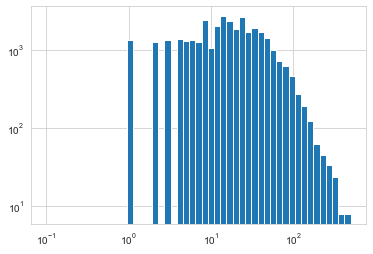

In [52]:
# Obtaining the degree distribution
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.hist([d for n, d in G_cites.degree()], bins=np.logspace(np.log10(0.1),np.log10(500), 50))
plt.xscale('log')
plt.yscale('log')

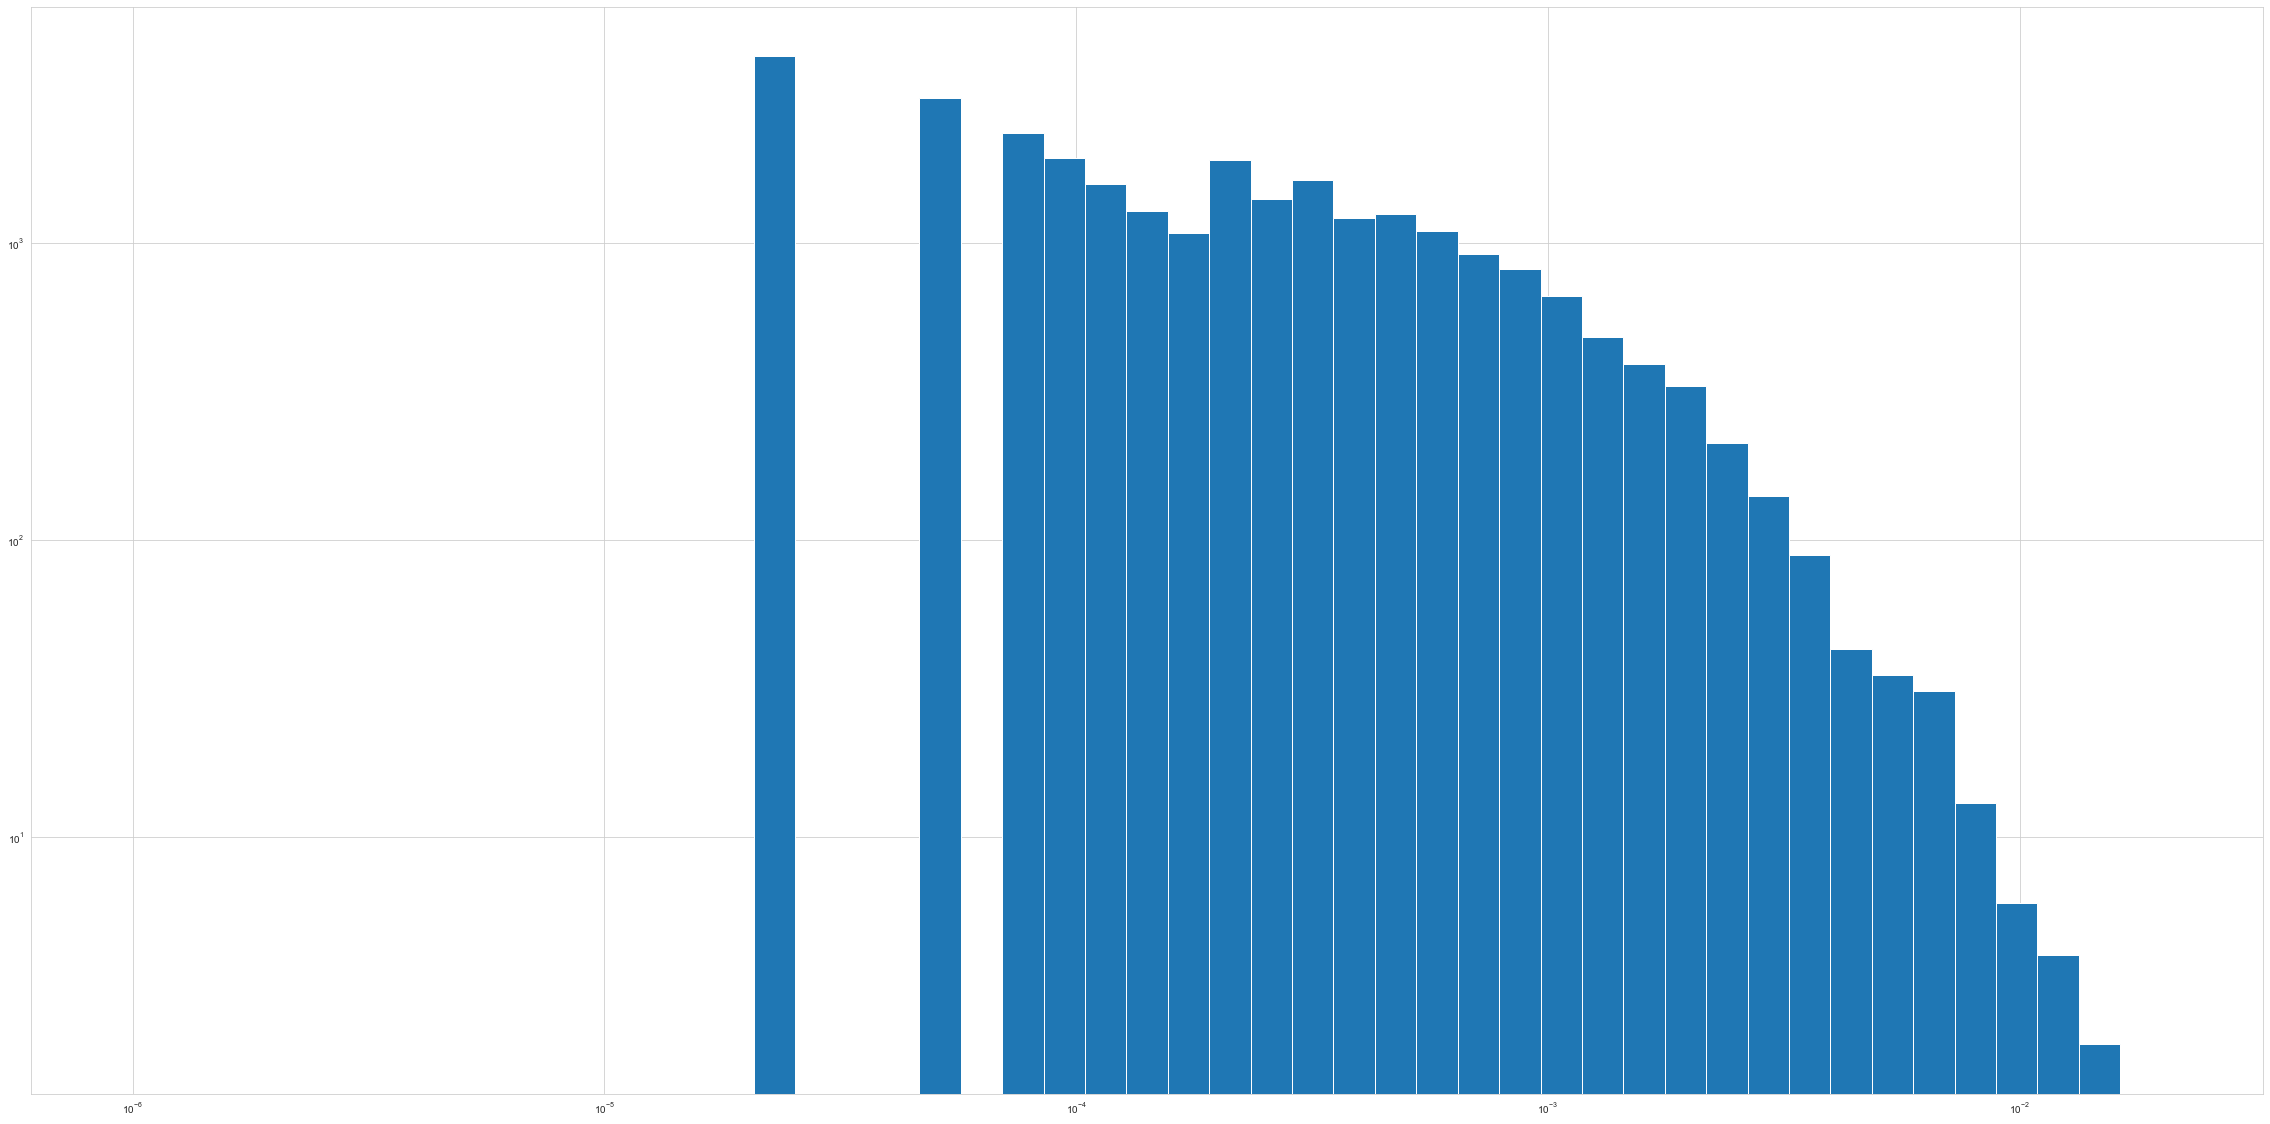

In [54]:
# Plotting centrality distribution
plt.hist(
    [v for v in nx.in_degree_centrality(G_cites).values()], 
    bins=np.logspace(np.log10(0.000001), np.log10(0.02), 50))
plt.xscale('log')
plt.yscale('log')

In [78]:
# Computing the clustering coefficient
clustering_vals = [v for v in nx.clustering(G_cites).values()]
print(np.mean(clustering_vals))


0.11894523821062691


 ## Sampling Methods
 There are a lot of ways we can sample graphs. Leskovec and Faloutsos introduce several, so we'll go through the highlight reel. 
 
 ### Random Node Selection
 
 #### Random Node Sampling
 This is where we grab a random set of nodes and induce a subgraph with just this set of nodes. This does **not** retain a power-law degree distribution. Let's sample 50 random nodes from Wikipedia. Then we'll look at the degree distribution in the induced subgraph.

In [79]:
import random
nodes_to_keep = set(random.sample([n for n in G_cites.nodes], 50))
G_cite_rns = nx.subgraph_view(G_cites, lambda b: True if b in nodes_to_keep else False)

(array([44.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

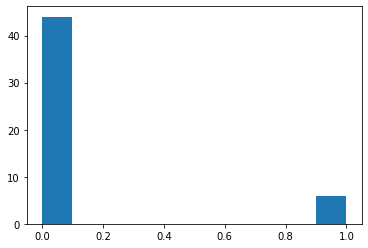

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([d for n, d in G_cite_rns.degree()])

#### Interactive Moment: 
Did random node sampling produce an induced subgraph with a degree distrubtion you think is plausible? What about the connectivity of the graph? Does that seem like a useful sampling method? Why or why not?

We can also sample nodes according to their [PageRank](https://en.wikipedia.org/wiki/PageRank) weight or their degree. Do you think this would produce a good approximation of the degree distribution? Why or why not?

### Sampling using Edges

#### Random Edge Sampling
We can also sample edges at random; what problems can you foresee with this approach? These will tend to have sparse connectivity and lack community structure. What about the graph diameter? Will it be what you expect it to be?

#### Random Node-Edge Sampling
This is where we pick a random node (uniformly at random) and then pick an edge incident to that node. This tends to perform better, but it is biased towards higher-degree nodes -- can you explain why that might be the case? 

Let's give both of these a try; we'll do random edge sampling first!

In [57]:
# Random edge sampling
import random
edges_to_keep = random.sample([e for e in G_cites.edges()], 500)

set_of_nodes_to_keep = set()
# keeping nodes that are incident to a sampled edge
for e in edges_to_keep:
    set_of_nodes_to_keep.add(e[0])
    set_of_nodes_to_keep.add(e[1])
    
G_cite_res = nx.subgraph_view(G_cites, lambda b: True if b in set_of_nodes_to_keep else False)

/usr/local/lib/python3.9/site-packages/networkx/utils/decorators.py:1254: FutureWarning: Pass filter_node=<function <lambda> at 0x1b79cca60> as keyword args. From NetworkX version 3.4 passing these as positional arguments will result in an error


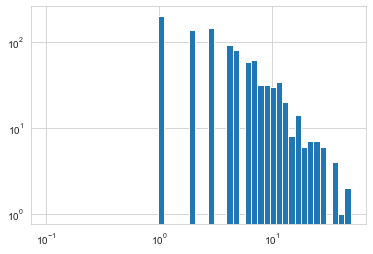

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([d for n, d in G_cite_res.degree()], bins=np.logspace(np.log10(0.1),np.log10(50), 50))
plt.xscale('log')
plt.yscale('log')

#### Your Turn!
Now it's your turn to implement random node-edge sampling (RNES). 

In [ ]:
# Random edge sampling

nodes_to_keep = set()
for i in range(25):
    # sample a node and an edge incident on it. 
    # keep the node and its neighbor on that edge.
    
G_cite_rnes = nx.subgraph_view(G_cites, lambda b: True)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([d for n, d in G_cite_rnes.degree()], bins=np.logspace(np.log10(0.1),np.log10(100), 50))
plt.xscale('log')
plt.yscale('log')

#### Interactive Moment:
What did your degree distriubtions look like this time? 
Okay, so we're maybe seeing a high-degree node here and there, and the distributions look better, but we're not all of the way there yet. Let's check centrality and clustering coefficients next.

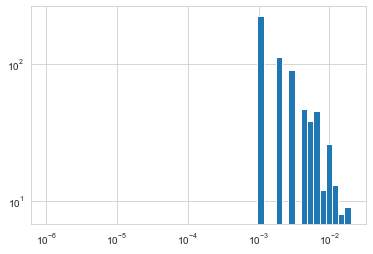

In [59]:
# Plotting centrality distribution for RES sample graph
plt.hist(
    [v for v in nx.in_degree_centrality(G_cite_res).values()], 
    bins=np.logspace(np.log10(0.000001), np.log10(0.02), 50))
plt.xscale('log')
plt.yscale('log')

In [60]:
# Plotting centrality distribution for RNES graph
plt.hist(
    [v for v in nx.in_degree_centrality(G_cite_rnes).values()], 
    bins=np.logspace(np.log10(0.000001), np.log10(0.02), 50))
plt.xscale('log')
plt.yscale('log')

NameError: name 'G_cite_rnes' is not defined

In [ ]:
# Computing the clustering coefficients for RES & RNES graphs
clustering_vals = [v for v in nx.clustering(G_cite_res).values()]
print('The average clustering for RES is ' + str(np.mean(clustering_vals)))

clustering_vals = [v for v in nx.clustering(G_cite_rnes).values()]
print('The average clustering for RNES is ' + str(np.mean(clustering_vals)))


### Sampling by Exploration

#### Random Node-Neighbor Sampling
Here, we select a node uniformly at random **and** gather up all its neighbors as well. This tends to match out-degree distribution pretty well, but in-degree distribution and community structure don't match up quite as nicely.

#### Random Walk Sampling
We pick a node uniformly at random and then pick a random neighbor to go to. Then we go to a randomly chosen neighbor of *that* node, and so on. However, at each step, with probability $p$ (usually $p = 0.15$ in the literature), we go back to our start node and restart the walk. If we do a bunch of steps and don't visit enough nodes to get a large enough sample, we pick another node as our start node (this assumes we found a small component or a node that is a sink). 

#### Random Jump Sampling
This is the same as random walk sampling, except with probability $p$, instead of going back to our start node, we jump to another randomly chosen node in the graph (drawn uniformly at random). This avoids the concerns about getting stuck that we had with random walk sampling.

Let's implement random jump sampling. Keep sampling until you have 50 nodes, and then tell me about your degree distribution!

In [ ]:
# Your Turn!
G_cite_rjs = nx.DiGraph()

while len(G_cite_rjs.nodes) < 50:
    # do something

In [ ]:
plt.hist([d for n, d in G_cite_rjs.degree()])

### Forest Fire Sampling
Okay, so that was pretty neat! We saw a more plausible degree distrubtion, and we got to do some random walking. Now we're going to look at another type of sampling that Leskovec and Faloutsos suggest for the **back-in-time** sampling goal. It's called **Forest Fire Sampling**, and you start by randomly picking a seed node $v$. Then we pick a random number $x$ that's geometrically distributed with mean $m = \frac{p_f}{1-p_f}$: $p(x) = (1-m)^k m$. We select $x$ of $v$'s out-links. For each out-link, we choose to burn it with probability $p_f$. If a link $(v, w)$ burns, the node $w$ at its endpoint also can burn its own links, and so on. L & F found that this works pretty well for back-in-time sampling with relatively low values of $p_f$ ($0 \leq p_f \leq 0.4$) and for static sampling with higher values of $p_f$ ($p_f \geq 0.6$). 
 
 
Let's attempt forest fire sampling with different values of $p_f$. We'll then compare our results to an older version of the graph. 

In [11]:
from littleballoffur import ForestFireSampler

# because this code is grumpy, we have to give each node a numeric index starting at 0.
import networkx as nx
import pandas as pd

G_cites_sequential = nx.relabel_nodes(G_cites, {node:idx for idx, node in enumerate(G_cites.nodes)})


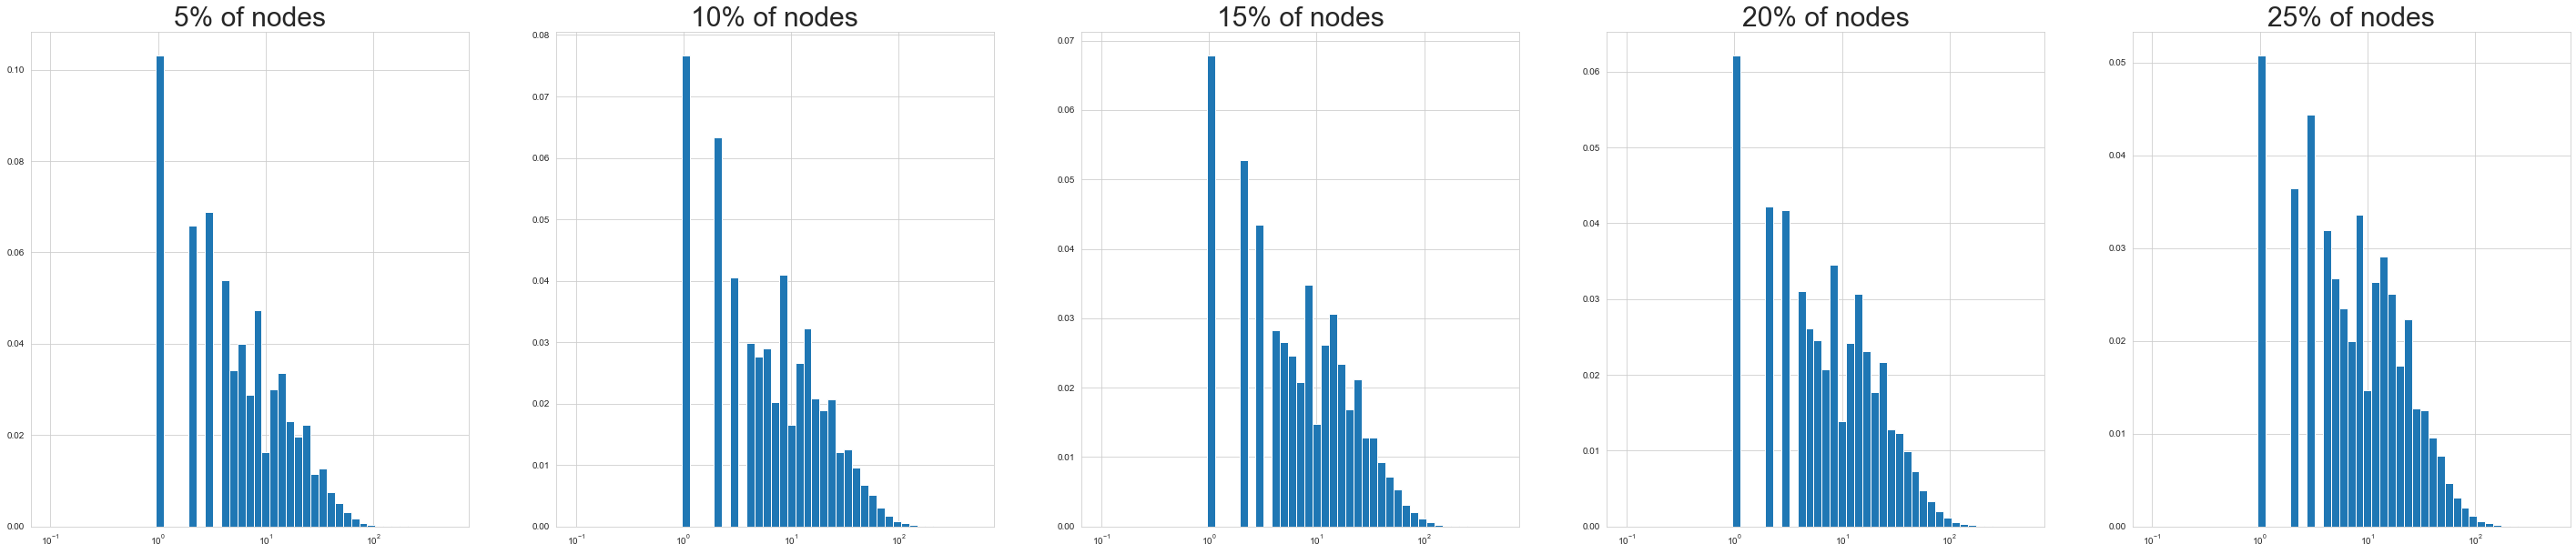

In [48]:
# First we'll try different sample sizes:
plt.rcParams['figure.figsize'] = (50, 10)

fig, ax = plt.subplots(1, 5)
for idx in range(1, 6):
    G_cite_ffs = ForestFireSampler(number_of_nodes = idx * int( len(G_cites.nodes)/20)).sample(
        G_cites_sequential.to_undirected()
    )
    ax[idx - 1].hist(
        [d for n, d in G_cite_ffs.degree()], 
        bins=np.logspace(np.log10(0.1),np.log10(500), 50), 
        density=True
    )
    ax[idx - 1].set_title(str(5 * idx) + '% of nodes', size=30)
    ax[idx - 1].set_xscale('log')
    ax[idx - 1].set_yscale('log')

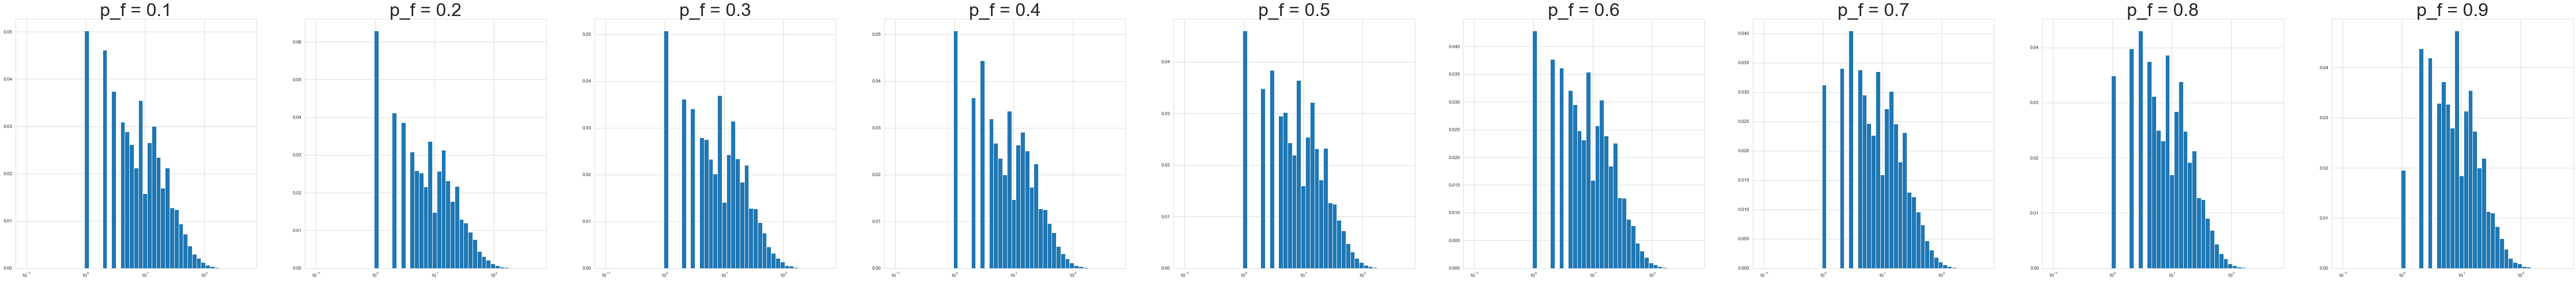

In [49]:
plt.rcParams['figure.figsize'] = (100, 10)

fig, ax = plt.subplots(1, 9)
for idx in range(1, 10):
    G_cite_ffs = ForestFireSampler(p=0.1 * idx, number_of_nodes = 5 * int( len(G_cites.nodes)/20)).sample(
        G_cites_sequential.to_undirected()
    )
    ax[idx - 1].hist(
        [d for n, d in G_cite_ffs.degree()], 
        bins=np.logspace(np.log10(0.1),np.log10(500), 50), 
        density=True)
    ax[idx - 1].set_title("p_f = %.1f"%(0.1 * idx), size=40)
    ax[idx - 1].set_xscale('log')
    ax[idx - 1].set_yscale('log')

### Comparing to previous iterations of the graph

Let's look at versions of the graph that existed before 1993, 1994, 1995, and 1996. We'll compare them to our forest fire sampling results and see how they stack up.

/usr/local/lib/python3.9/site-packages/networkx/utils/decorators.py:1254: FutureWarning: Pass filter_node=<function <lambda> at 0x1b8418280> as keyword args. From NetworkX version 3.4 passing these as positional arguments will result in an error
/usr/local/lib/python3.9/site-packages/networkx/utils/decorators.py:1254: FutureWarning: Pass filter_node=<function <lambda> at 0x1b7cac670> as keyword args. From NetworkX version 3.4 passing these as positional arguments will result in an error
/usr/local/lib/python3.9/site-packages/networkx/utils/decorators.py:1254: FutureWarning: Pass filter_node=<function <lambda> at 0x1b7d0f430> as keyword args. From NetworkX version 3.4 passing these as positional arguments will result in an error
/usr/local/lib/python3.9/site-packages/networkx/utils/decorators.py:1254: FutureWarning: Pass filter_node=<function <lambda> at 0x1b7d860d0> as keyword args. From NetworkX version 3.4 passing these as positional arguments will result in an error


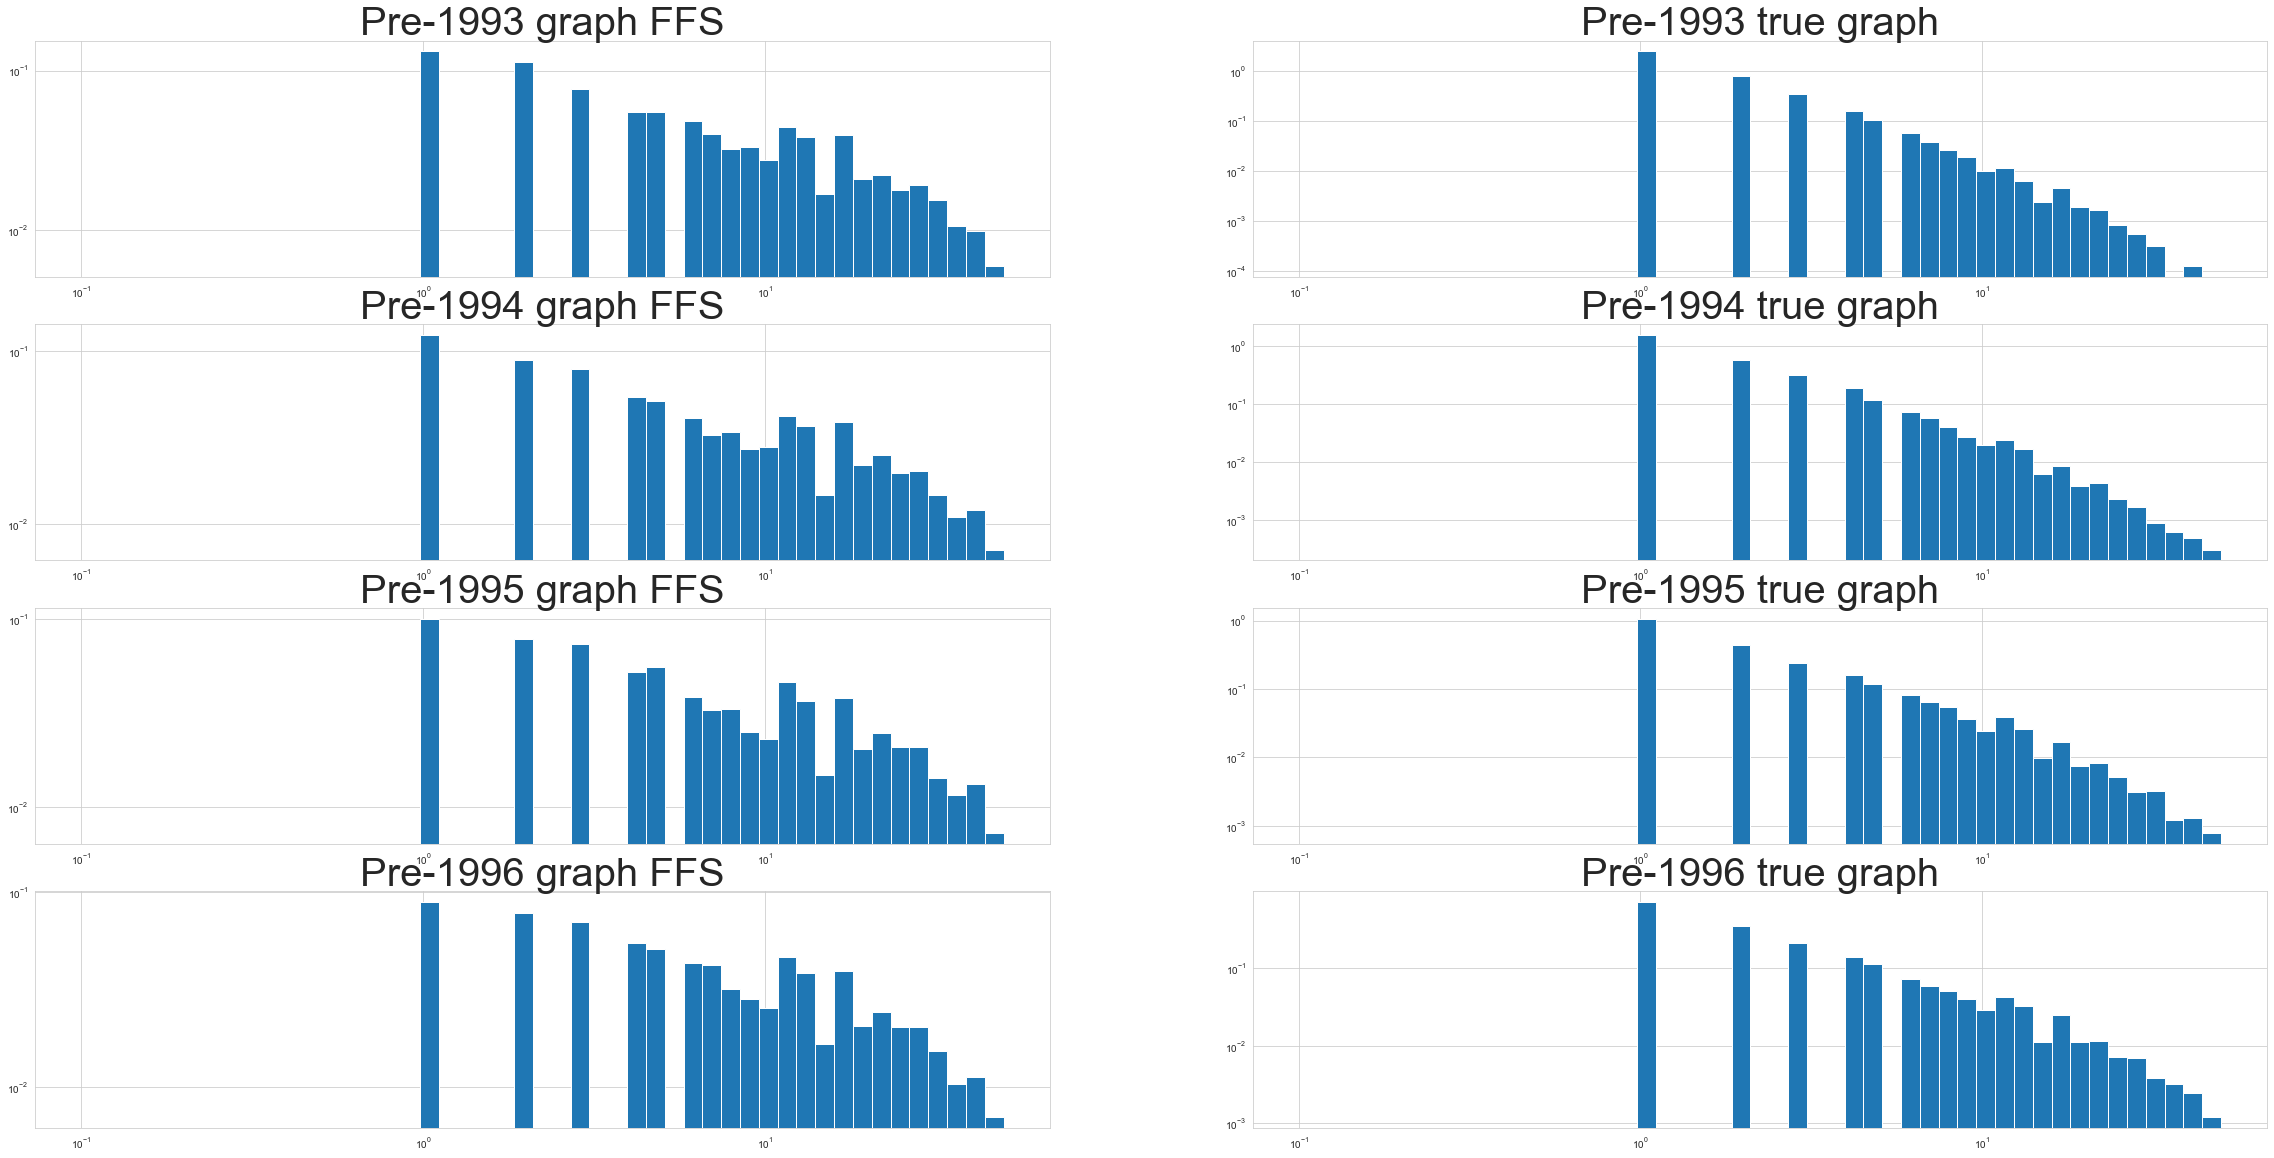

In [53]:
# Your Turn!

plt.rcParams['figure.figsize'] = (40, 20)

# toggle values of P_f to see if any produce an optimal result.
P_f = 0.25
def retrieve_year(node):
    try:
        return G_cites.nodes[node]['date'].year
    except Exception as e:
        return 2024
fig, ax = plt.subplots(4, 2)
for idx, yr in enumerate([1993, 1994, 1995, 1996]):
    G_cite_year = nx.subgraph_view(G_cites, lambda b:retrieve_year(b) <= yr)
    G_cite_ffs = ForestFireSampler(p=P_f, number_of_nodes = len(G_cite_year)).sample(
        G_cites_sequential.to_undirected()
    )
    ax[idx, 0].hist(
        [d for n, d in G_cite_ffs.degree()], 
        bins=np.logspace(np.log10(0.1),np.log10(50), 50), 
        density=True
    )
    ax[idx, 0].set_xscale('log')
    ax[idx, 0].set_yscale('log')

    ax[idx, 0].set_title('Pre-' + str(yr) + ' graph FFS', size=40)
    ax[idx, 1].hist(
        [d for n, d in G_cite_year.degree()], 
        bins=np.logspace(np.log10(0.1),np.log10(50), 50), 
        density=True
    )
    ax[idx, 1].set_xscale('log')
    ax[idx, 1].set_yscale('log')

    ax[idx, 1].set_title('Pre-' + str(yr) + ' true graph', size=40)